This problem comes from OpenAI's [Requests for Research 2.0](https://blog.openai.com/requests-for-research-2/). And the description of this problem is as following:

----

Train an LSTM to solve the XOR problem: that is, given a sequence of bits, determine its parity. The LSTM should consume the sequence, one bit at a time, and then output the correct answer at the sequence’s end. Test the two approaches below:

Generate a dataset of random 100,000 binary strings of length 50. Train the LSTM; what performance do you get?
Generate a dataset of random 100,000 binary strings, where the length of each string is independently and randomly chosen between 1 and 50. Train the LSTM. Does it succeed? What explains the difference?

In [1]:
import numpy
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
import seaborn as sns
from matplotlib import pyplot as plt

To keep results reproducible, we need to control all the random numbers

# 1. Data generation and split

In [2]:
random_state=41

In [3]:
def generate_dataset(dataset_size, MAX_LEN, variable_length, random_state):
    numpy.random.seed(random_state)
    dataset=[]
    targets=[]
    for i in tqdm(range(dataset_size)):
        if variable_length:
            length=numpy.random.randint(2,MAX_LEN+1)
        else:
            length=MAX_LEN
        dataset.append(numpy.random.randint(0,2,size=(length)))
        labels=int(sum(dataset[-1])%2)
        targets.append(labels)
    return dataset,targets

In [4]:
dataset,targets=generate_dataset(100000,50,True,random_state=41)

A Jupyter Widget

Split the dataset into train+valid and test, then we can split train+valid into train and valid

In [5]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(dataset, targets, test_size=0.2, random_state=random_state)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.25, random_state=random_state)

# 2. Baseline

Now we can test the performance of our baseline: Logistic Regression.
As the length could be variable, we need to padding those shorter sequences with zeros

In [6]:
def padding(x,length):
    return list(x)+[0]*(length-len(x))
def test_baseline(X_train, X_test, y_train, y_test):
    length=[len(x) for x in X_train]
    max_length=max(length)
    X_train=[padding(x,max_length) for x in X_train]
    X_test=[padding(x,max_length) for x in X_test]
    clf=LogisticRegression(C=0.01, penalty='l1')
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    return accuracy_score(y_test,y_pred)

In [7]:
baseline_accuracy=test_baseline(X_train, X_test, y_train, y_test)
print('Baseline accuracy is %0.4f'%baseline_accuracy)

Baseline accuracy is 0.4988


# 3. LSTM

First, we need to generate batch data. Here we use class Dataset provided by pytorch

In [8]:
def collate_fn(data):
    sequences=numpy.array([d[0] for d in data])
    labels=numpy.array([d[1] for d in data])
    return sequences,labels

class XOR_Dataset(Dataset):
    def __init__(self, dataset,target):
        self.dataset=dataset
        self.target=target

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx],self.target[idx]

Then we can define our LSTM

In [9]:
class LSTM_CLF(nn.Module):
    def __init__(self, emb_dim, hidden_size, use_cuda):
        super(LSTM_CLF, self).__init__()
        self.embedding = nn.Embedding(3, emb_dim)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_size,
            num_layers=1,
        )
        self.clf=nn.Sequential(
            nn.Linear(hidden_size,2),
        )
        self.padding_idx=2
        self.use_cuda=use_cuda
        if self.use_cuda:
            self.cuda()

    def forward(self, sequences, lengths):
        self.embedding.weight.data[self.padding_idx]=0
        if self.use_cuda:
            sequences=sequences.cuda()
        sequences=Variable(sequences)
        emb=self.embedding(sequences)
        pack = pack_padded_sequence(emb, lengths, batch_first=True)
        output, hidden = lstm.rnn(pack)
        hidden=hidden[0].squeeze()
        return self.clf(hidden)

In [10]:
def test_lstm(lstm,X_test,y_test,use_cuda):
    sequences,labels,lengths=sort_and_padding(X_test,y_test,use_cuda)
    labels=Variable(labels)
    final_layer=lstm(sequences,lengths)
    y_pred=final_layer.topk(1)[1].cpu().data.numpy()
    return accuracy_score(y_test,y_pred)

To handle variable length of the input sequences, we need to sort each batch according to their length.
We also need to rearrange the labels accordig to the order of sequences.

In [11]:
def sort_and_padding(sequences,labels,use_cuda):
    '''
    sequences: numpy.array
    labels:numpy.array
    '''
    sequences=numpy.array(sequences)
    labels=numpy.array(labels)
    lengths = [len(x) for x in sequences]
    lengths=Variable(torch.FloatTensor(lengths))
    ordered_len,ordered_idx=lengths.sort(0, descending=True)
    ordered_len=ordered_len.cpu().data.numpy().astype(numpy.int32)
    sequences=sequences[ordered_idx.cpu().data.numpy()]
    labels=labels[ordered_idx.cpu().data.numpy()]
    for i in range(sequences.shape[0]):
        padding_size=int(ordered_len[0]-ordered_len[i])
        sequences[i]=numpy.append(sequences[i],numpy.ones(padding_size)*2)
        sequences[i]=list(sequences[i].astype(numpy.int32))
    sequences=numpy.array(list(sequences))
    sequences=torch.LongTensor(sequences)
    labels=torch.from_numpy(labels)
    if use_cuda:
        sequences=sequences.cuda()
        labels=labels.cuda()
    return sequences,labels,ordered_len

In [14]:
emb_dim=5
hidden_size=10
use_cuda=False
MAX_ITER=11
lr=0.01
losses=[]
best_loss=10000000
valid_every=100
idx=0
batch_size=100
lstm_train_dataset=XOR_Dataset(X_train,y_train)
lstm=LSTM_CLF(emb_dim,hidden_size,use_cuda)
optimizer = optim.SGD(lstm.parameters(), lr=lr)
criteria=nn.CrossEntropyLoss()

In [15]:
for epoch in tqdm(range(MAX_ITER)):
    lstm_train=iter(DataLoader(lstm_train_dataset,batch_size=batch_size,collate_fn=collate_fn))
    for sequences,labels in lstm_train:
        sequences,labels,lengths=sort_and_padding(sequences,labels,use_cuda)
        idx+=1
        optimizer.zero_grad()
        labels=Variable(labels)
        final_layer=lstm.forward(sequences,lengths)
        loss=criteria(final_layer,labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().data.numpy()[0])
        if idx%valid_every==0:
            sequences,labels,lengths=sort_and_padding(X_valid,y_valid,use_cuda)
            labels=Variable(labels)
            final_layer=lstm.forward(sequences,lengths)
            loss=criteria(final_layer,labels)
            loss=loss.cpu().data.numpy()[0]
            if loss<best_loss:
                print(test_lstm(lstm,X_test,y_test,use_cuda))

A Jupyter Widget

0.50115



Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/adoni/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/adoni/Keck/src/tqdm/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/adoni/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



0.50435
0.50345
0.5023
0.50495
0.5025
0.5015
0.50405
0.5033
0.5023
0.50405
0.50325
0.5035
0.50235
0.50335
0.50435
0.5047
0.50155
0.503



KeyboardInterrupt: 

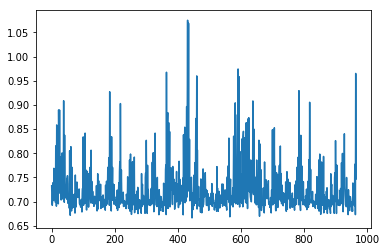

In [22]:
plt.plot(losses)
plt.show()